## SHRINKAGE METHODS

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

### usiamo i dati engineered con log-price

In [2]:
data=pd.read_csv("Data/aircraft_price_clean.csv")
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [3]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data

,engine_power,max_speed,cruise_speed,stall_speed,fuel_tank,all_eng_roc,out_eng_roc,takeoff_distance,landing_distance,empty_weight,length,wing_span,range,price
0,145.0,104.0,91.0,46.0,36.0,450.0,900.0,1300.0,2050.0,1180.0,303.0,449.0,370.0,1300000.0
1,85.0,89.0,83.0,44.0,15.0,600.0,720.0,800.0,1350.0,820.0,247.0,433.0,190.0,1230000.0
2,90.0,90.0,78.0,37.0,19.0,650.0,475.0,850.0,1300.0,810.0,257.0,420.0,210.0,1600000.0
3,85.0,88.0,78.0,37.0,19.0,620.0,500.0,850.0,1300.0,800.0,257.0,420.0,210.0,1300000.0
4,65.0,83.0,74.0,33.0,14.0,370.0,632.0,885.0,1220.0,740.0,257.0,420.0,175.0,1250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,1000.0,351.0,334.0,56.0,3819.0,3242.0,1930.0,2280.0,12050.0,7856.0,521.0,572.0,1879.0,4100000.0
503,720.0,312.0,288.0,89.0,578.0,2380.0,2280.0,3043.0,11200.0,6837.0,521.0,572.0,1722.0,3584000.0
504,720.0,290.0,275.0,87.0,390.0,2236.0,3230.0,3017.0,11200.0,6389.0,521.0,572.0,1515.0,3200000.0
505,620.0,275.0,270.0,77.0,382.0,1750.0,2940.0,2446.0,9474.0,5164.0,440.0,512.0,1336.0,3240000.0


In [4]:
# Prepare features and target
X = pd.get_dummies(data.drop('price', axis=1), drop_first=True)
y = data['price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Define lambda values for regularization
lambda_values = np.logspace(-2, 3, 150)

In [5]:
# Create Ridge pipeline with scaling
pipeline = make_pipeline(StandardScaler(), Ridge())

# Grid search for best alpha
param_grid = {'ridge__alpha': lambda_values}
ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best Ridge alpha: {best_alpha}")

Best Ridge alpha: 14.267977510008587


In [6]:
# Evaluate on test set
ridge_best = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f"Ridge Test MSE: {ridge_mse:.2f}")

Ridge Test MSE: 143718926232.31


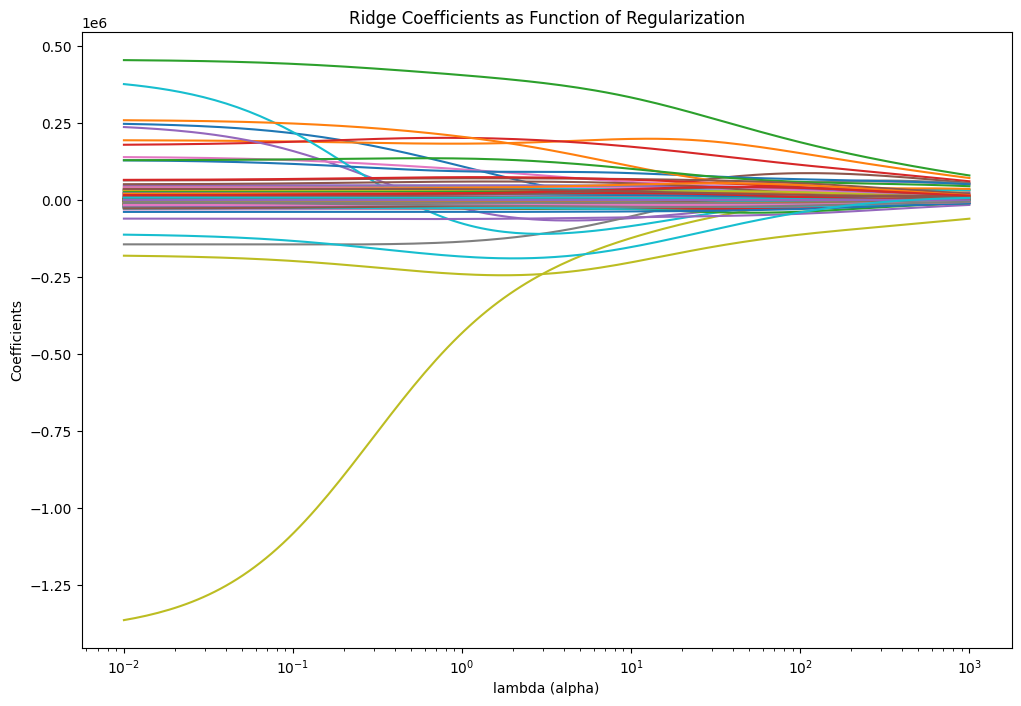

In [7]:
# Plot coefficients vs lambda
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as Function of Regularization')
plt.show()

Stai osservando come Ridge "controlla" i coefficienti al crescere della regolarizzazione: li rende piccoli, ma non li azzera — e questo è esattamente il comportamento previsto.

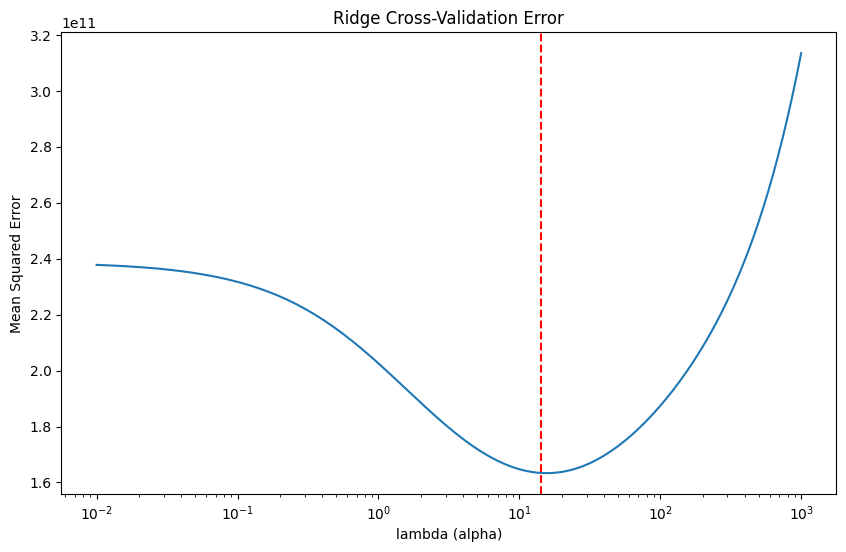

In [8]:
# Plot cross-validation errors
cv_scores = []
for alpha in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = -cross_val_score(pipe, X_train, y_train, cv=kf, 
                             scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, cv_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('lambda (alpha)')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Error')
plt.show()

## LASSO 

In [9]:
# Create Lasso pipeline with scaling
lasso_pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))


# Grid search for best alpha
lasso_cv = GridSearchCV(lasso_pipe, 
                       {'lasso__alpha': lambda_values},
                       scoring='neg_mean_squared_error',
                       cv=10)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['lasso__alpha']
print(f"Best Lasso alpha: {best_alpha}")

Best Lasso alpha: 1000.0


In [10]:
# Evaluate on test set
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f"Lasso Test MSE: {lasso_mse:.2f}")

# Number of non-zero coefficients
final_coefs = lasso_best.named_steps['lasso'].coef_
print(f"Number of non-zero coefficients: {np.sum(final_coefs != 0)}")

Lasso Test MSE: 141780051437.37
Number of non-zero coefficients: 142


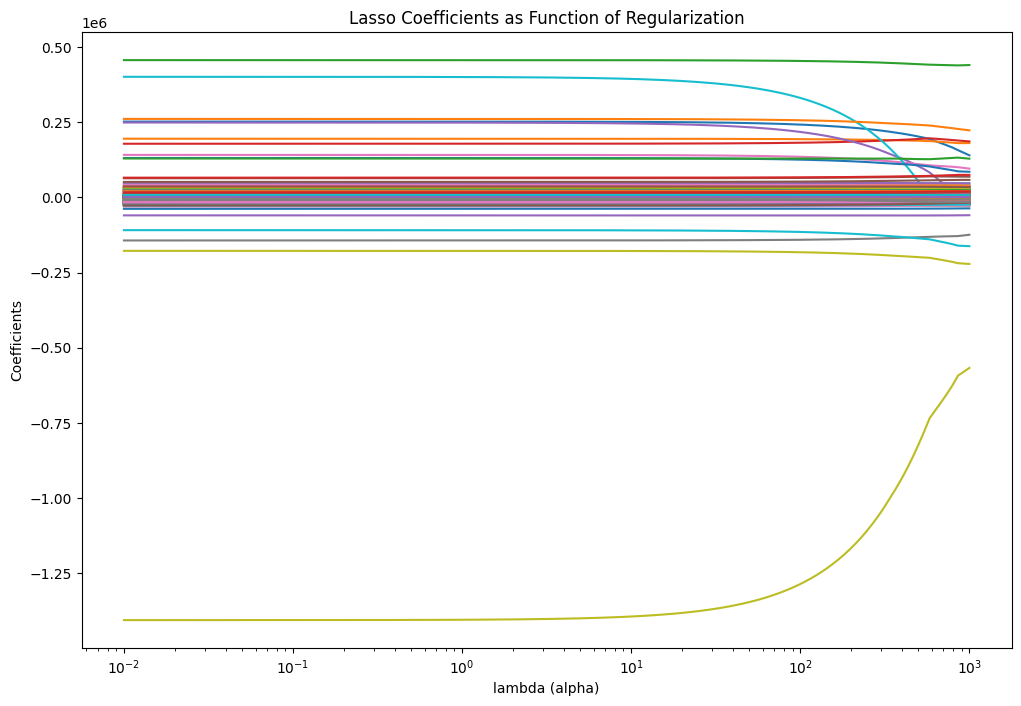

In [11]:
# Plot Lasso coefficients for different lambda values
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=a, max_iter=10000))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as Function of Regularization')
plt.show()